# Cloud Detection `Inference`

## Sentinel-2 Satellite

### GPU 確認

In [1]:
!nvidia-smi

Sun Sep  3 06:16:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:08:00.0  On |                  Off |
| 64%   84C    P2   270W / 300W |  40775MiB / 49140MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### PyTorch 確認

In [2]:

import torch
print(torch.__version__)
torch.cuda.is_available()

2.0.1


True

## インポート

In [3]:
import os, glob, random, time, gc
from tqdm.notebook import tqdm

import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [15]:
PATH_MODEL = '/workspace/src/output/008/best_model.pth'
PATH_OUTPUT = f'output/009/'
os.makedirs(PATH_OUTPUT, exist_ok=True)

Text(0.5, 1.0, 'Optical Image')

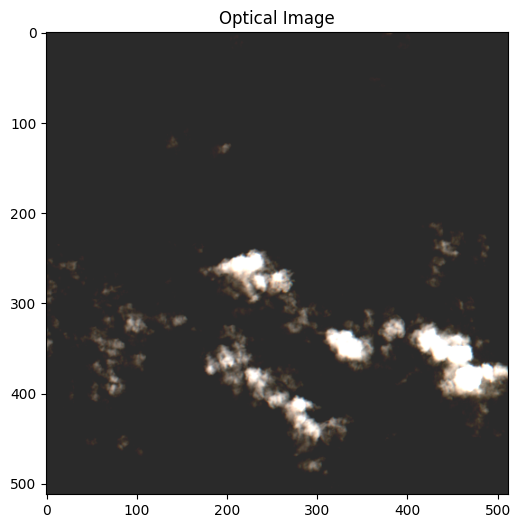

In [24]:
PATH_ID = f'../sample/data/train_features/zxpp/'

imgs = []

for i in [2, 3, 4]:
    img = cv2.imread(PATH_ID + f'B{str(i).zfill(2)}.tif', cv2.IMREAD_UNCHANGED)
    imgs.append(img)
    
imgs = np.stack(imgs, axis=2)
tifffile.imwrite('input/sample.tif', imgs)

imgs = []
plt.figure(figsize=(8, 6))
for i in [2, 3, 4]:
    img = cv2.imread(PATH_ID + f'B{str(i).zfill(2)}.tif', cv2.IMREAD_UNCHANGED)
    img = img.astype(np.float32)
    img = np.clip(img, 400, 2400) / 2400
    imgs.append(img)
    
imgs = np.stack(imgs, axis=2)
imgs = (imgs * 255).astype(np.uint8)

plt.imshow(imgs)
plt.title('Optical Image')

In [25]:
PATHS_IMG = glob.glob('input/*.tif')
df = pd.DataFrame(PATHS_IMG, columns=['path'])
df.head()

,path
0,input/sample.tif


## DataLoop

In [26]:
class DataTransform():
    def __init__(self):
        self.data_transform = {
            "val": A.Compose(
                [
                  ToTensorV2(),
                ]
            )
        }

    def __call__(self, phase, img):
        return self.data_transform[phase](image=img)

class CloudInferenceDataset(Dataset):
    def __init__(self, df, phase, transform,):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        row = self.df.iloc[index]
        PATH = row['path']
        img = tifffile.imread(PATH)
        img = img.astype(np.float32)
        
        img = self.transform(self.phase, img)["image"]
        return img

## モデル
from: https://www.kaggle.com/code/junkoda/base-unet-model-for-the-1st-place/notebook

In [27]:
import yaml
import timm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base.initialization import initialize_decoder
from segmentation_models_pytorch.base import modules as md

In [28]:
"""
U-Net decoder from Segmentation Models PyTorch
https://github.com/qubvel/segmentation_models.pytorch
"""
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        dropout=0,
    ):
        super().__init__()

        conv_in_channels = in_channels + skip_channels

        # Convolve input embedding and upscaled embedding
        self.conv1 = md.Conv2dReLU(
            conv_in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

        self.dropout_skip = nn.Dropout(p=dropout)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            skip = self.dropout_skip(skip)
            x = torch.cat([x, skip], dim=1)

        x = self.conv1(x)
        x = self.conv2(x)

        return x


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        use_batchnorm=True,
        dropout=0,
    ):
        super().__init__()

        encoder_channels = encoder_channels[::-1]

        # Computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        self.center = nn.Identity()

        # Combine decoder keyword arguments
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, use_batchnorm=use_batchnorm, dropout=dropout)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, features):
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x
    
in_chans = 3

cfg = yaml.safe_load(f"""
model:
  encoder: maxvit_tiny_tf_512.in1k  # I also use resnest26d
  pretrained: False    # Use True! False due to internet connection
  decoder_channels: [256, 128, 64, 32, 16]
  dropout: 0.0
  in_chans: {in_chans}
""")

def _check_reduction(reduction_factors):
    """
    Assume spatial dimensions of the features decrease by factors of two.
    For example, convnext start with stride=4 cannot be used in my code.
    """
    r_prev = 1
    for r in reduction_factors:
        if r / r_prev != 2:
            raise AssertionError('Reduction assumed to increase by 2: {}'.format(reduction_factors))
        r_prev = r

class Model(nn.Module):
    # The main U-Net model
    # See also TimmUniversalEncoder in Segmentation Models PyTorch
    def __init__(self, cfg, pretrained=True, tta=None):
        super().__init__()
        name = cfg['model']['encoder']
        dropout = cfg['model']['dropout']
        pretrained = pretrained and cfg['model']['pretrained']

        self.encoder = timm.create_model(name, 
                                         features_only=True, 
                                         pretrained=pretrained, 
                                         in_chans=cfg['model']['in_chans'],)
        encoder_channels = self.encoder.feature_info.channels()

        _check_reduction(self.encoder.feature_info.reduction())

        decoder_channels = cfg['model']['decoder_channels']  # (256, 128, 64, 32, 16)
        print('Encoder channels:', name, encoder_channels)
        print('Decoder channels:', decoder_channels)

        assert len(encoder_channels) == len(decoder_channels)

        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            dropout=dropout,
        )

        self.segmentation_head = smp.base.SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=1, activation=None, kernel_size=3,
        )

        initialize_decoder(self.decoder)        

    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(features)
        y_pred = self.segmentation_head(decoder_output)

        return y_pred
    
model = Model(cfg=cfg)

Encoder channels: maxvit_tiny_tf_512.in1k [64, 64, 128, 256, 512]
Decoder channels: [256, 128, 64, 32, 16]


## 推論

0it [00:00, ?it/s]

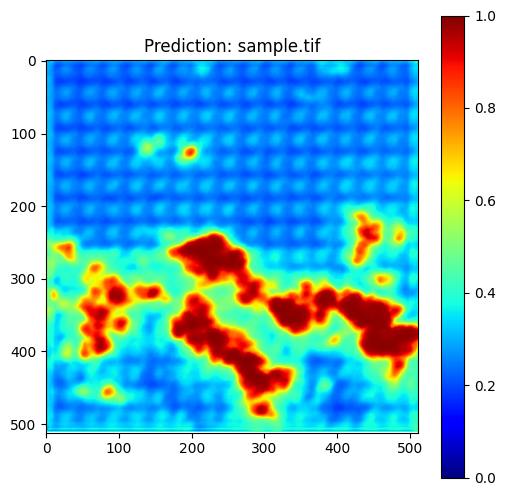

In [30]:
BATCH_SIZE = 1

test_dataset = CloudInferenceDataset(df, phase="val", transform=DataTransform())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = torch.load(PATH_MODEL)
model.eval()
for i, (img) in tqdm(enumerate(test_dataloader)):
    with torch.no_grad():
        img = img.cuda()
        output = model(img)
        output = output.squeeze(dim=1)
        preds = torch.sigmoid(output)

        for batch_i, pred in enumerate(preds.cpu().numpy()):
            plt.figure(figsize=(6, 6))
            
            PATH = df['path'].iloc[i*BATCH_SIZE + batch_i]
            fname = os.path.basename(PATH)
            fname_wo_ext = fname.split('.')[0]
            
            plt.title(f'Prediction: {fname}')
            plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
            plt.colorbar()
            plt.savefig(f"{PATH_OUTPUT}/predict_{fname_wo_ext}.png")
            plt.show();

            tifffile.imwrite(f"{PATH_OUTPUT}/{fname}", pred)